In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2022-05-19 16:44:26--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  28.7MB/s    in 9.9s    

2022-05-19 16:44:37 (26.3 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:

!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
import pyspark
import numpy as np
import pandas as pd

Problem Domain

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Platforms').getOrCreate()

# Read data from CSV file
#you can download it from here:   https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/CC_GENERAL.csv
cd=spark.read.csv('/content/combined-data.csv', header=True, inferSchema=True,nullValue='NULL')

cd.show(5)

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows



In [ ]:
cd.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)



In [ ]:
cd1=cd.na.drop()

In [ ]:
cd1.count()

1411

In [ ]:
cd.na.drop(how="any", thresh=2).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
|   342|         5653|        1|     android|              36|         5|       null|     null|
|   849|         5654|        1|      iphone|              40|         5|       null|     null|
|  1277|         5655|        1|     win

Filling Missing Value

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['count_buyId', 'avg_price'], 
    outputCols=["{}_imputed".format(c) for c in ['count_buyId', 'avg_price']]
    ).setStrategy("median")

In [ ]:
# Add imputation cols to df
cd2 = imputer.fit(cd1).transform(cd1)

In [ ]:
cd2.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|   937|         5652|        1|     android|              39|         0|          1|      1.0|                  1|              1.0|
|  1623|         5659|        1|      iphone|             129|         9|          1|     10.0|                  1|             10.0|
|    83|         5661|        1|     android|             102|        14|          1|      5.0|                  1|              5.0|
|   121|         5665|        1|     android|              39|         4|          1|      3.0|                  1|              3.0|
|   462|         5666|        1|     android|              90|

In [ ]:
cd2.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- count_buyId_imputed: integer (nullable = true)
 |-- avg_price_imputed: double (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler
customer_df.columns
assemble=VectorAssembler(inputCols=[
 'userSessionId',
 'teamLevel',
 'count_gameclicks',
 'count_hits',
 'count_buyId',
 ], outputCol='features')
assembled_data=assemble.transform(cd1)
assembled_data.show(2)

+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|            features|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+
|   937|         5652|        1|     android|              39|         0|          1|      1.0|[5652.0,1.0,39.0,...|
|  1623|         5659|        1|      iphone|             129|         9|          1|     10.0|[5659.0,1.0,129.0...|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|            features|        standardized|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+--------------------+
|   937|         5652|        1|     android|              39|         0|          1|      1.0|[5652.0,1.0,39.0,...|[0.75853973680677...|
|  1623|         5659|        1|      iphone|             129|         9|          1|     10.0|[5659.0,1.0,129.0...|[0.75947918800239...|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.4032548278750885
Silhouette Score: 0.5375106679619152
Silhouette Score: 0.5510748476727184
Silhouette Score: 0.5552641302660388
Silhouette Score: 0.48582367702383533
Silhouette Score: 0.4697183261714663
Silhouette Score: 0.40639717937591235
Silhouette Score: 0.43536253728303


Text(0, 0.5, 'cost')

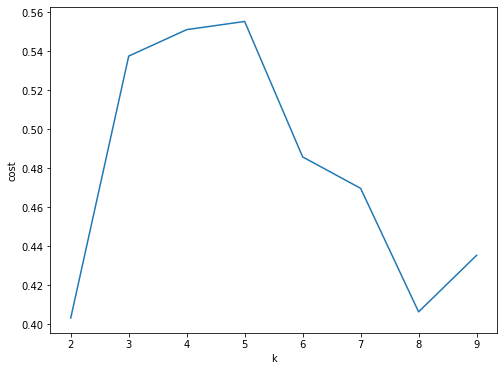

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
final_clustering=KMeans(featuresCol='standardized', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)
clusters_output=KMeans_fit.transform(data_scale_output)

In [ ]:
#notice the last column [prediction]
clusters_output.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+--------------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|            features|        standardized|prediction|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------------+--------------------+----------+
|   937|         5652|        1|     android|              39|         0|          1|      1.0|[5652.0,1.0,39.0,...|[0.75853973680677...|         1|
|  1623|         5659|        1|      iphone|             129|         9|          1|     10.0|[5659.0,1.0,129.0...|[0.75947918800239...|         1|
|    83|         5661|        1|     android|             102|        14|          1|      5.0|[5661.0,1.0,102.0...|[0.75974760262971...|         1|
|   121|         5665|        1|     android|              39|         4|          1|      3.0|[5665.0,1.0